In [141]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

# Natural language Toolkit
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import f1_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [ ]:
# Set directory
directory_david = '/run/media/david-vp/davidvp-files/DSMMaster/advanced-nlp/final-proj/Genre Classification Dataset/'
directory_miguel ='/Users/Miguel/Desktop/BSE/Term2/Advanced NLP/Advanced_NLP_Project/Genre Classification Dataset/'
directory_dominik = ''

directory = directory_dominik

In [ ]:
# Load train data
filename ="train_data.txt"

df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_train.drop(columns=df_train.columns[0], axis=1, inplace=True)
df_train.columns =['title', 'genre', 'description']
df_train['genre']=df_train['genre'].apply(lambda x: x.strip())

df_train.head()

<ipython-input-33-35d79816ace5>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
# Load test data
filename = "test_data_solution.txt"
df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_test.drop(columns=df_test.columns[0], axis=1, inplace=True)
df_test.columns =['title', 'genre', 'description']
df_test['genre']=df_test['genre'].apply(lambda x: x.strip())

df_test.head()

<ipython-input-34-e5ec557b696e>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...


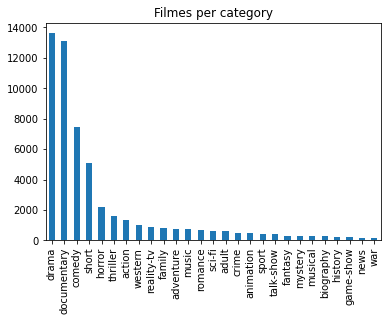

In [ ]:
df_train.genre.value_counts().plot(kind='bar')
plt.title("Filmes per category")
plt.show()

In [ ]:
# Only keep some columns
list_labels = ["drama", "comedy", "horror", "thriller", "action", "western", "sci-fi"]

df_train = df_train[df_train["genre"].isin(list_labels)]
df_test = df_test[df_test["genre"].isin(list_labels)]

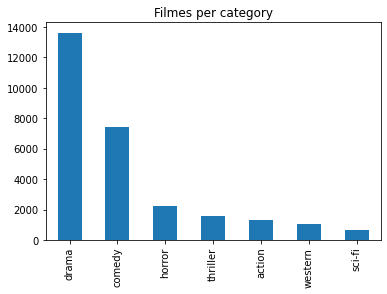

In [ ]:
df_train.genre.value_counts().plot(kind='bar')
plt.title("Filmes per category")
plt.show()

# Preprocessing

## Remove Stopwords

In [ ]:
def remove_stopwords(text, stopwords):
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)

In [ ]:
# Defining stopwords
# using predefined english stopwords
stop_words = set(stopwords.words('english'))

# including additional stopwords
my_stopwords = ['lol', 'people', 'expand',
                'really', 'deal','u', 'much', 'get', 'good', 'act', 'put', 'man', 'a', 'think', 'one',
                'say', 'like', 'go', 'do', 'head', 'yet', 'wall', 'guess', 'keep', 'oh', 'north', 'oil',
                'prize', 'involved', 'might', 'medium''among', 'might', 'make', 'do', 'may', 'year', 'give',
                'also', 'law', 'etc', 'wait', 'prove', 'mean', 'thing', 'rest', 'middle','rnr','u','fuck','make',
                'would', 'know', 'lot', 'see', 'president', 'done', 'even', 'many', 'ever', 'want', 'made',
                'got', 'going', 'need', 'view', 'something', 'lasting', 'still', 'way', 'every', 'anyone', 
                'first', 'look', 'medium', 'time', 'since', 'life', 'probably', 'anything', 'come', 
                'long', 'could', 'anything', 'donald', 'back', 'sure', 'last', 'nothing', 'rate', 'well',
                'left', 'le', 'someone', 'example', 'seen', 'day', 'said', 'world', 'making', 'far', 'care',
                'shit','america','issue','new', 'actually','never','whole','exposed','imapct','side','single']
stop_words.update(my_stopwords)

In [ ]:
df_train['description'] = df_train['description'].apply(remove_stopwords, args=(stop_words,))

### Lemmatize

In [ ]:
# Tokenize: Split the sentence into words
docs = df_train['description']

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Lemmatize list of words and join
lemmatized_output = [''.join([lemmatizer.lemmatize(w) for w in doc]) for doc in docs]
df_train['description'] = lemmatized_output
df_train.head()

,title,genre,description
0,Oscar et la dame rose (2009),drama,"Listening conversation doctor parents, 10-year..."
1,Cupid (1997),thriller,brother sister past incestuous relationship cu...
3,The Secret Sin (1915),drama,"help unemployed father ends meet, Edith twin s..."
4,The Unrecovered (2007),drama,film's title refers un-recovered bodies ground...
6,"""Pink Slip"" (2009)",comedy,"tough economic times Max Joey run ideas until,..."


# Baseline

## Random assignment

Choose randomly among the genres and use the share of the genres in the training data set as probability that a specific genre is assigned

In [59]:
genre_priors = df_train.genre.value_counts() / df_train.shape[0]
genre_priors = pd.DataFrame(data={"genre":genre_priors.index, "probability": genre_priors.values})
genre_priors = genre_priors.sort_values("genre")

In [67]:
# Predict genres for test data
prior_predictions = np.random.choice(genre_priors.genre.values, size = df_test.shape[0], p = genre_priors.probability.values)

In [68]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, prior_predictions, average="weighted")
recall = recall_score(true_labels, prior_predictions, average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.323258453173051
Recall:  0.3229421060192501


## TF-IDF based dictionary

In [109]:
def create_important_dict(df, no_words):
  """Creates dictionary with the no_words number of words that have the
  highest TF-IDF score per topic for the provided data 

  Parameters
  ----------
  data : pandas series
      A Series containing text data with one row per topic
  no_words : int
      The number of words that will be included in the dictionary for each topic

  Returns
  -------
  important_dict: dict
      dictionary with the words that have the highest tf-idf score per topic
  """

  data = df.description
  genres = df.genre

  # create TF-IDF DataFrame
  vectorizer = TfidfVectorizer(max_df=0.9)
  X = vectorizer.fit_transform(data)
  tokens = vectorizer.get_feature_names_out()
  X = X.toarray()
  X = pd.DataFrame(X, columns=tokens)
  X = X.T

  X.columns = genres
  # create dictionary with most important words per topic
  important_dict = {}
  for col in X.columns:
    most_important = X.sort_values(by=col, ascending=False).head(no_words).index
    important_dict[col] = list(most_important)

  return important_dict

In [115]:
def tfidf_predictions(data, important_dict):
  """Predicts based on an dictionary which topic each text belongs to. 

  Parameters
  ----------
  data : pandas series
      A Series containing text data
  important_dict: dict
      A dictionary with the words that are relevant for the classification

  Returns
  -------
  prediction: list
      contains a int value representing the topic predicted for each text 
  """

  # Initializing the list
  predictions = []
  i = 0
  # Iterrating over the texts (rows)
  for row in data:

    # Splitting the text in words
    words = row.split()

    # Initializing a dictionary to count how many words associated with a topic occur in each text
    count_dict = {}

    # Itterating over the topics in the important_dict dictionary
    for key in list(important_dict.keys()):
      top_words = set(important_dict[key])
      score = len(set(words) & top_words)
      count_dict[key] = score

    # Check if there is one topic with the largest number of occurences and make this the prediction    
    if sum(value == max(count_dict.values()) for value in count_dict.values()) == 1 :
      i += 1
      predictions.append(list(count_dict.keys())[list(count_dict.values()).index(max(count_dict.values()))])

    # Otherwise, make the prediction random based on the distribution of topics within the original data  
    else:
      predictions.append(np.random.choice(genre_priors.genre.values, size = 1, p = genre_priors.probability.values)[0])

  print(i/len(predictions))
  return list(predictions)

In [116]:
# Create a dictionary with the most important words per genre 
genre_descriptions = df_train.groupby(['genre'])['description'].apply(','.join).reset_index()
important_dict = create_important_dict(genre_descriptions, 50)

In [117]:
tfidf_predictions = tfidf_predictions(df_test["description"], important_dict)

0.3025068237322224


In [118]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, tfidf_predictions, average="weighted")
recall = recall_score(true_labels, tfidf_predictions, average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.41022630322282355
Recall:  0.4038931188047694


## Baseline David

In [119]:
terms_by_genre = {}

# Iterrate over genres
for genre in df_train['genre'].unique():

    # Join descriptions of all movies for each genre
    genre_df = df_train[df_train['genre'] == genre]
    all_descriptions = ' '.join(genre_df['description'])
    all_words = all_descriptions.split()
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    top_words = [word for word, count in sorted_words[:50]]
    terms_by_genre[genre] = top_words

In [139]:
def predict_genre(description):
    words = description.split()
    genre_scores = {}
    for genre in terms_by_genre:
        top_words = set(terms_by_genre[genre])
        score = len(set(words) & top_words)
        genre_scores[genre] = score
    predicted_genre = max(genre_scores, key=genre_scores.get)
    return predicted_genre

In [140]:
predict_genre = df_test["description"][:100].apply(predict_genre)

In [122]:
predicted_genres = df_test["description"].apply(predict_genre)

true_labels = df_test["genre"]
f1 = f1_score(true_labels, predicted_genres, average="weighted")
recall = recall_score(true_labels, predicted_genres, average="weighted")

print("F1: ",f1)

print("Recall: ",recall)

F1:  0.4604663751146275
Recall:  0.4458411147823589


# GRU Network

In [142]:
# input and target columns
X_train = df_train["description"].values
y_train = pd.get_dummies(df_train["genre"]).values

X_test = df_test["description"].values
y_test = pd.get_dummies(df_test["genre"]).values

# find the maximum length of the descriptions
maxlen = max(len(description) for description in X_train)

maxlen = 1000

In [143]:
# tokenize the input text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [144]:
# define the model architecture
model = Sequential()
model.add(Embedding(10000, 64, input_length=maxlen))
model.add(GRU(64, dropout=0.2))
model.add(Dense(7, activation="softmax"))

# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
168/697 [======>.......................] - ETA: 5:30 - loss: 1.4363 - accuracy: 0.4900

KeyboardInterrupt: ignored

In [ ]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average="weigthed")
recall = recall_score(y_true, y_pred, average="weigthed")
print("F1 score:", f1)
print("Recall score:", recall)